<a href="https://colab.research.google.com/github/TransRadOnc-HIT/multi-omics-SSMP2023/blob/main/Hands_on_2_MachineLearningView1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning view to multi-omics integration 1**

---

This notebook outlines the steps and methodologies applied for multi-omics  survival prediction. The primary focus is on feature selection and dimensionality reduction techniques to enhance the performance of the Cox Proportional Hazards model. The two main strategies employed are LASSO regularization and Principal Component Analysis (PCA).

## Table of Contents:

1. **Data Loading and Initial Structuring**:  
   
2. **Feature Reduction with Univariate Analysis**:  
   Preliminary feature selection based on the univariate significance of individual predictors.

3. **CV-Lasso Cox Proportional Hazards Model**:  
   - Implementing the Cox model with LASSO regularization.

4. **Principal Component Analysis (PCA)**:  
   - Applying PCA for dimensionality reduction.
   - Evaluating the Cox model's performance on the reduced feature space and determining the optimal number of components.

5. **Comparison**:  
   Contrasting the performance of the Cox Proportional Hazards model using PCA versus LASSO regularization.
---



---



The dataset for this notebook consists of data from 298 H&N cancer patients across four different institutions.

- **Data Reference**: [The Cancer Imaging Archive - Head-Neck-PET-CT](https://wiki.cancerimagingarchive.net/display/Public/Head-Neck-PET-CT)

There is **no need to download the data**, but in case you want to do so, please download the dataset from the specified Google Drive link. Once done, please configure the `data_path` variable to point to the directory where the data has been stored.

**Omics Examined**: FDG-PET/CT, RT CT, and RTDOSE


### **Setup**

We'll install the lifelines and scikit-survival packages, essential for the survival analysis tasks we'll be tackling later in this notebook.

In [ ]:
!pip install lifelines
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=03724b83f6cf02643c637876be410b0d172de1a78d606ee763f27bb7844f58f3
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.2 MB/s eta 0:00:00


In the next cell, we're importing necessary libraries for our analysis: numpy and pandas for data manipulation, matplotlib and seaborn for data visualization, sklearn for machine learning tools and preprocessing, and os for handling file paths.

In [ ]:
from itertools import combinations
import statsmodels.stats.multitest as smt
from lifelines import CoxPHFitter
import numpy as np #Fundamental package for scientific computing
import pandas as pd #For data manipulation and analysis
import matplotlib.pyplot as plt #2D plotting library
import seaborn as sns #Python data visualization library based on matplotlib
import warnings #Typically issued in situations where it is useful to alert the user of some condition in a program
from collections import Counter #Supports iterations
from os import path
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler # Feature scaling
from sklearn.model_selection import train_test_split
import warnings
from lifelines import KaplanMeierFitter
warnings.filterwarnings('ignore') #Ignores all warnings

data_path = 'https://raw.githubusercontent.com/TransRadOnc-HIT/multi-omics-SSMP2023/main/data/hands-on2'

### **Data loading and intial structuring**



In this section, we import the survival and preprocessed omics datasets, refining the data for consistency in identifiers and structuring.

In [ ]:
# Loading the provided data files

files = [
    "CLI_preprocessed.csv",
    "DD_preprocessed.csv",
    "PET_preprocessed.csv",
    "CT_preprocessed.csv"
]

dataframes = {}
for file_ in files:
    if file_ != "survival.csv":  # Handle the survival data separately
        key = file_.split('_preprocessed.csv')[0]
        dataframes[key] = pd.read_csv(f'{data_path}/{file_}', index_col=0)

# Loading the survival data
survival = pd.read_csv(f'{data_path}/survival.csv', index_col=0)

# Drop any rows with NaN values
survival.dropna(inplace=True)

# Displaying the first few rows of each dataframe for verification
dfs_sample = {key: df.head() for key, df in dataframes.items()}
dfs_sample['survival'] = survival.head()


We next combine the dataframes in every possible way based on the index and return a dictionary of all merged combinations

In [ ]:
def merge_dataframes_on_index(dfs):
    """
    Merges the provided list of dataframes on their index.

    Args:
    - dfs (list): List of dataframes to merge.

    Returns:
    - DataFrame: Merged dataframe.
    """
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')

    # Drop rows with any missing values
    merged_df.dropna(inplace=True)

    return merged_df

def combine_dataframes(dataframes):
    """
    Combines the provided dataframes in every possible combination.

    Args:
    - dataframes (dict): Dictionary of dataframes to combine.

    Returns:
    - dict: Dictionary containing combined dataframes.
    """
    # Start by adding individual dataframes
    combined_dataframes = dataframes.copy()

    # Print shape for individual dataframes
    for key, df in dataframes.items():
        print(f"{key} shape: {df.shape}")

    # Now create combinations and add to the combined_dataframes
    keys = list(dataframes.keys())
    #keys.remove("CLI")

    for r in range(2, len(keys) + 1):  # for combining 2 up to all dataframes
        for subset in combinations(keys, r):

            merged_df = merge_dataframes_on_index([dataframes[key] for key in subset])
            combined_name = "_".join(subset)
            combined_dataframes[combined_name] = merged_df
            print(f"{combined_name} shape: {merged_df.shape}")

    return combined_dataframes
dataframes_all = combine_dataframes(dataframes)

CLI shape: (298, 46)
DD shape: (175, 312)
PET shape: (271, 204)
CT shape: (274, 331)
CLI_DD shape: (175, 358)
CLI_PET shape: (271, 250)
CLI_CT shape: (274, 377)
DD_PET shape: (172, 516)
DD_CT shape: (175, 643)
PET_CT shape: (271, 535)
CLI_DD_PET shape: (172, 562)
CLI_DD_CT shape: (175, 689)
CLI_PET_CT shape: (271, 581)
DD_PET_CT shape: (172, 847)
CLI_DD_PET_CT shape: (172, 893)


### **Feature Reduction with Univariate Analysis**

 We next perform univariate Cox Proportional Hazard analysis on each feature of a dataframe, returning adjusted p-values for each feature using the specified multiple comparison correction method. Given the time-intensive nature of this process, we've previously saved the results. Hence, there's no need to execute this function again.

In [ ]:
def univariate_coxph(df, survival, method='fdr_bh'):
    """
    df: DataFrame with feature data
    survival: DataFrame with survival data
    method: String indicating which correction method to use.
            Some options include 'bonferroni', 'sidak', 'holm', and 'fdr_bh'.
    """
    p_values = {}
    for col in df.columns:
        # Using only one feature at a time
        X_uni = df[[col]]
        data_uni = pd.concat([X_uni, survival], axis=1).dropna()

        cph = CoxPHFitter(penalizer=0.01) # Add penalizer if necessary
        try:
            cph.fit(data_uni, duration_col='Survival', event_col='Death')
            p_values[col] = cph.summary.loc[col, 'p']
        except:
            print(f"Convergence error for feature {col}. Skipping.")

    # Adjust p-values for multiple comparisons
    pvals = list(p_values.values())
    reject, pvals_corrected, _, _ = smt.multipletests(pvals, method=method)

    # Create a dictionary of adjusted p-values
    adjusted_p_values = dict(zip(p_values.keys(), pvals_corrected))

    return adjusted_p_values

In [ ]:
# Gather p-values for each dataframe
all_pvalues = {}
for name, df in dataframes_all.items():
    print(f"Processing {name}")
    #all_pvalues[name] = univariate_coxph(df, survival)

Processing CLI
Processing DD
Processing PET
Processing CT
Processing CLI_DD
Processing CLI_PET
Processing CLI_CT
Processing DD_PET
Processing DD_CT
Processing PET_CT
Processing CLI_DD_PET
Processing CLI_DD_CT
Processing CLI_PET_CT
Processing DD_PET_CT
Processing CLI_DD_PET_CT


In [ ]:
#for key, values in all_pvalues.items():
#    # Convert dictionary values to DataFrame
#    df = pd.DataFrame(list(values.items()), columns=["Variable", "P-value"])
#
#    # Save to CSV
#    output_path = key + "_pvalues.csv"
#    df.to_csv(output_path, index=False)#
#
#    print(f"Saved {key} _ {output_path}")

Saved CLI _ CLI_pvalues.csv
Saved DD _ DD_pvalues.csv
Saved PET _ PET_pvalues.csv
Saved CT _ CT_pvalues.csv
Saved CLI_DD _ CLI_DD_pvalues.csv
Saved CLI_PET _ CLI_PET_pvalues.csv
Saved CLI_CT _ CLI_CT_pvalues.csv
Saved DD_PET _ DD_PET_pvalues.csv
Saved DD_CT _ DD_CT_pvalues.csv
Saved PET_CT _ PET_CT_pvalues.csv
Saved CLI_DD_PET _ CLI_DD_PET_pvalues.csv
Saved CLI_DD_CT _ CLI_DD_CT_pvalues.csv
Saved CLI_PET_CT _ CLI_PET_CT_pvalues.csv
Saved DD_PET_CT _ DD_PET_CT_pvalues.csv
Saved CLI_DD_PET_CT _ CLI_DD_PET_CT_pvalues.csv


Here, we will load the results and move forward.

In [8]:
data_path = 'https://raw.githubusercontent.com/TransRadOnc-HIT/multi-omics-SSMP2023/main/data/hands-on2/pvalue/'
files = [
    "CLI_pvalues.csv",
    "PET_pvalues.csv",
    "CT_pvalues.csv",
    "DD_pvalues.csv",
    "CLI_CT_pvalues.csv",
    "DD_PET_pvalues.csv",
    "CLI_DD_pvalues.csv",
    "PET_CT_pvalues.csv",
    "CLI_DD_CT_pvalues.csv",
    "CLI_DD_PET_pvalues.csv",
    "CLI_PET_CT_pvalues.csv",
    "CLI_PET_pvalues.csv",
    "DD_PET_CT_pvalues.csv",
    "CLI_DD_PET_CT_pvalues.csv"
]

all_pvalues = {}
for file_ in files:
    if file_ != "survival.csv":
        key = file_.split('_pvalues.csv')[0]
        all_pvalues[key] = pd.read_csv(f'{data_path}/{file_}', index_col=0)

Next, we provide a detailed summary of our analysis, highlighting key statistics like the median p-value and counts of significant features across different thresholds for each dataframe. This overview gives a concise representation of feature significance within various dataframes

In [9]:
# Print out the summary
print("\nSummary:\n")
header = ["Dataframe Name", "Total Features", "Significant Features (p<0.05)", "Median p-value", "Features (p<0.05)", "Features (p<0.1)", "Features (p<0.25)", "Features (p<0.5)"]
print("{:<25}{:<20}{:<30}{:<20}{:<20}{:<20}{:<20}{:<20}".format(*header))
print('-'*155)

for name, p_values in all_pvalues.items():
    total_features = len(p_values)
    significant_features = sum(1 for p in p_values["P-value"] if p < 0.05)

    # Calculate median
    sorted_p_values = sorted(p_values["P-value"])
    median_p_value = np.median(sorted_p_values)

    # Calculate the number of features that will stay for various p-value thresholds
    features_005 = sum(1 for p in p_values["P-value"] if p < 0.05)
    features_01 = sum(1 for p in p_values["P-value"] if p < 0.1)
    features_025 = sum(1 for p in p_values["P-value"] if p < 0.25)
    features_05 = sum(1 for p in p_values["P-value"] if p < 0.5)

    print(f"{name:<25}{total_features:<20}{significant_features:<30}{median_p_value:<20.5f}{features_005:<20}{features_01:<20}{features_025:<20}{features_05:<20}")

print("\n")



Summary:

Dataframe Name           Total Features      Significant Features (p<0.05) Median p-value      Features (p<0.05)   Features (p<0.1)    Features (p<0.25)   Features (p<0.5)    
-----------------------------------------------------------------------------------------------------------------------------------------------------------
CLI                      46                  6                             0.63333             6                   6                   9                   13                  
PET                      204                 46                            0.19614             46                  73                  106                 146                 
CT                       331                 39                            0.56984             39                  47                  82                  135                 
DD                       312                 60                            0.32895             60                  83            

we proceed to filter out features with p-values greater than 0.05 and visualize the distribution of the remaining significant p-values. This graphical representation aids in comparing the significance of features across different models, helping us discern patterns and trends

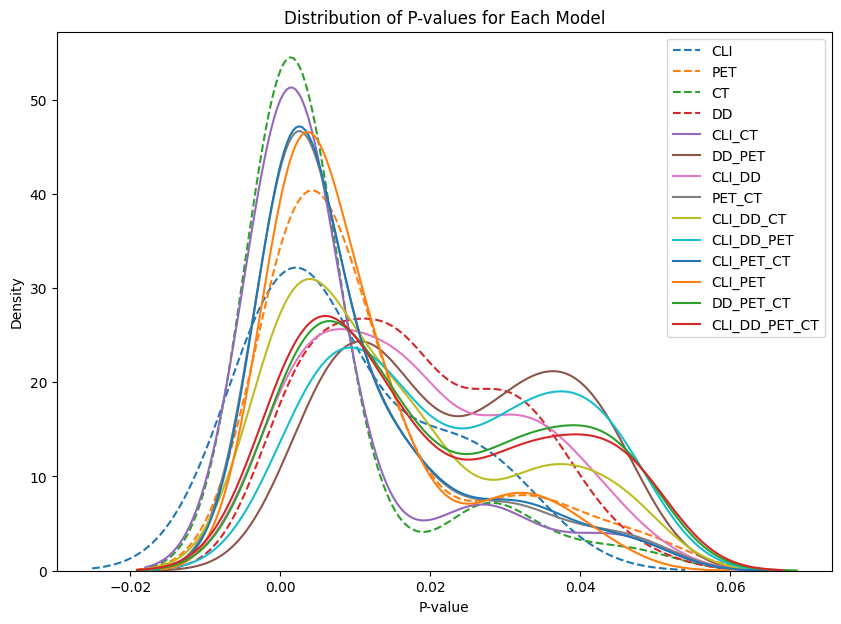

In [10]:
# Filter features with p-values > 0.05 and plot the distribution of remaining p-values
plt.figure(figsize=(10,7))
for name, p_values in all_pvalues.items():
    significant_p_values = [p for p in p_values["P-value"] if p < 0.05]
    linestyle = '--' if '_' not in name else '-'
    sns.kdeplot(significant_p_values, label=name, linestyle=linestyle)

plt.xlabel("P-value")
plt.ylabel("Density")
plt.title("Distribution of P-values for Each Model")
plt.legend()

Next, we refine the datasets by dynamically adjusting the p-value threshold based on the number of combined omics data within each dataframe. This adaptive approach ensures that the features retained in multi-omics datasets are more stringent in terms of significance, optimizing for the complexity of integrating multiple data types

In [12]:

print("Dataframe shapes after filtering based on dynamic p-value threshold:\n")
print(f"{'Dataframe Name':<25}{'Threshold':<15}{'New Shape':<15}")
print('-'*55)
dataframes_allt = dataframes_all.copy()
# Filter features in each dataframe based on dynamic p-value threshold
for name, df in dataframes_all.items():
  if name != "DD_CT":
    # Set threshold based on number of times '_' appears in the name
    omics_count = name.count('_') + 1
    threshold_mapping = {
        1: 0.1,
        2: 0.1,
        3: 0.1,
        4 : 0.1
    }
    threshold = threshold_mapping[omics_count]

    # Get the significant features for this dataframe
    significant_features = [feature for feature, p_val in all_pvalues[name]["P-value"].items() if p_val < threshold]

    # Filter out features in the dataframe based on significance
    dataframes_allt[name] = df[significant_features]

    # Print threshold and new shape of the dataframe
    print(f"{name:<25}{threshold:<15.3f}{dataframes_allt[name].shape}")

Dataframe shapes after filtering based on dynamic p-value threshold:

Dataframe Name           Threshold      New Shape      
-------------------------------------------------------
CLI                      0.100          (298, 6)
DD                       0.100          (175, 83)
PET                      0.100          (271, 73)
CT                       0.100          (274, 47)
CLI_DD                   0.100          (175, 90)
CLI_PET                  0.100          (271, 78)
CLI_CT                   0.100          (274, 54)
DD_PET                   0.100          (172, 117)
PET_CT                   0.100          (271, 101)
CLI_DD_PET               0.100          (172, 123)
CLI_DD_CT                0.100          (175, 140)
CLI_PET_CT               0.100          (271, 108)
DD_PET_CT                0.100          (172, 157)
CLI_DD_PET_CT            0.100          (172, 161)




### **CV-Lasso Cox Proportional Hazards model**



Next, we employ the Lasso Cox Proportional Hazards model combined with cross-validation to further refine our feature set. By integrating Lasso regularization, this approach ensures that only the most predictive features, with respect to the survival data, are retained.

In [ ]:
from lifelines import CoxPHFitter
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
def lasso_cox_feature_selection(dataframes_train,  survival_data,dataframes_test=None,n_splits=5):
    """
    Applies Lasso Cox Proportional Hazards model with LassoCV on training dataframes in dataframes_train
    and truncates both training and test dataframes based on the selected features.

    Args:
    - dataframes_train (dict): Dictionary containing training dataframes.
    - dataframes_test (dict): Dictionary containing test dataframes.
    - survival_data (pd.DataFrame): Dataframe containing survival data with 'Survival' and 'Death' columns.
    - n_splits (int): Number of folds for cross-validation (default is 5).

    Returns:
    - tuple: Tuple containing dictionaries of truncated training and test dataframes with selected features.
    """
    truncated_dataframes_train = {}
    truncated_dataframes_test = {}

    # Set up the cross-validation scheme
    kfolds = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for key, df in dataframes_train.items():
        print(f"Processing {key} omics for train set...")

        # Print the shape before feature removal for train set
        print(f"Train set before feature removal, {key} omics shape: {df.shape}")

        # Merge the dataframe with survival_data for train set
        combined_data_train = df.merge(survival_data, left_index=True, right_index=True, how='inner')

        # Setting up feature selection model with LassoCV for train set
        lasso_cv = LassoCV(cv=kfolds, random_state=10)
        sel_ = SelectFromModel(lasso_cv)
        sel_.fit(combined_data_train.drop(columns=['Survival', 'Death']), combined_data_train['Survival'])

        # Get selected features for train set
        selected_features = combined_data_train.drop(columns=['Survival', 'Death']).columns[sel_.get_support()]
        truncated_df_train = df[selected_features]
        truncated_dataframes_train[key] = truncated_df_train

        if dataframes_test:
          # Truncate test dataframe using the selected features
          truncated_df_test = dataframes_test[key][selected_features]
          truncated_dataframes_test[key] = truncated_df_test

          # Print the shape after feature removal for test set
          print(f"Test set after feature removal, {key} omics shape: {truncated_df_test.shape}")

        # Print results for train set
        print(f"Train set after feature removal, {key} omics shape: {truncated_df_train.shape}")
        #print(f"Optimal alpha for train set {key} omics: {sel_.estimator_.alpha_}")


    return truncated_dataframes_train, truncated_dataframes_test

In [ ]:
dataframes_lasso, _ = lasso_cox_feature_selection(dataframes_allt, survival)


Processing CLI omics for train set...
Train set before feature removal, CLI omics shape: (298, 6)
Train set after feature removal, CLI omics shape: (298, 6)
Processing DD omics for train set...
Train set before feature removal, DD omics shape: (175, 83)
Train set after feature removal, DD omics shape: (175, 7)
Processing PET omics for train set...
Train set before feature removal, PET omics shape: (271, 73)
Train set after feature removal, PET omics shape: (271, 5)
Processing CT omics for train set...
Train set before feature removal, CT omics shape: (274, 47)
Train set after feature removal, CT omics shape: (274, 13)
Processing CLI_DD omics for train set...
Train set before feature removal, CLI_DD omics shape: (175, 90)
Train set after feature removal, CLI_DD omics shape: (175, 7)
Processing CLI_PET omics for train set...
Train set before feature removal, CLI_PET omics shape: (271, 78)
Train set after feature removal, CLI_PET omics shape: (271, 5)
Processing CLI_CT omics for train set

Next, we employ the Cox Proportional Hazards model with Lasso regularization to evaluate patient survival using different omics datasets. Each dataset is split into training and testing sets, and after handling missing values, it's used to train the model. The performance is then assessed using the Concordance Index, with results stored for each dataset.

In [ ]:
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

results_dict_lasso = {}

for name, df in dataframes_allt.items():

    print(f"Processing {name}")

    # Splitting data for this specific dataframe
    common_idx = df.index.intersection(survival.index)
    X_train, X_test, y_train, y_test = train_test_split(df.loc[common_idx], survival.loc[common_idx], test_size=0.2, random_state=42)
    # Combining features and target for lifelines input
    train_dataset = pd.concat([pd.DataFrame(X_train), y_train], axis=1)
    train_dataset.dropna(inplace=True)
    val_dataset = pd.concat([pd.DataFrame(X_test), y_test], axis=1)

    cph = CoxPHFitter(penalizer=0.01)
    cph.fit(train_dataset, duration_col='Survival', event_col='Death')
    ci = cph.score(val_dataset, scoring_method="concordance_index")


    results_dict_lasso[name] = {"CI": ci}

# Display the results
for name, result in results_dict_lasso.items():
    print(f"{name}:  CI = {result['CI']:.2f}")

Processing CLI
Processing DD
Processing PET
Processing CT
Processing CLI_DD
Processing CLI_PET
Processing CLI_CT
Processing DD_PET
Processing DD_CT
Processing PET_CT
Processing CLI_DD_PET
Processing CLI_DD_CT
Processing CLI_PET_CT
Processing DD_PET_CT
Processing CLI_DD_PET_CT
CLI:  CI = 0.45
DD:  CI = 0.64
PET:  CI = 0.62
CT:  CI = 0.58
CLI_DD:  CI = 0.49
CLI_PET:  CI = 0.67
CLI_CT:  CI = 0.67
DD_PET:  CI = 0.39
DD_CT:  CI = 0.71
PET_CT:  CI = 0.67
CLI_DD_PET:  CI = 0.68
CLI_DD_CT:  CI = 0.55
CLI_PET_CT:  CI = 0.71
DD_PET_CT:  CI = 0.33
CLI_DD_PET_CT:  CI = 0.67


Next we plot the Concordance Index (C-index) values for various omics and multi-omics datasets. This C-index is a measure of the model's predictive accuracy.

In [ ]:
import matplotlib.pyplot as plt

def plot_c_indexes(c_indexes):
    """
    Plots C-index values as a bar plot for each key.

    Args:
    - c_indexes (dict): Dictionary containing mean C-index values for each key.

    Returns:
    - None
    """
    # Extract keys and values from the dictionary
    keys = list(c_indexes.keys())
    values = list(c_indexes.values())

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='skyblue')
    plt.ylabel('Mean C-index')
    plt.xlabel('Keys')
    plt.title('Mean C-index for Each omics/Multi-omics')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()

    # Display the plot
    plt.show()


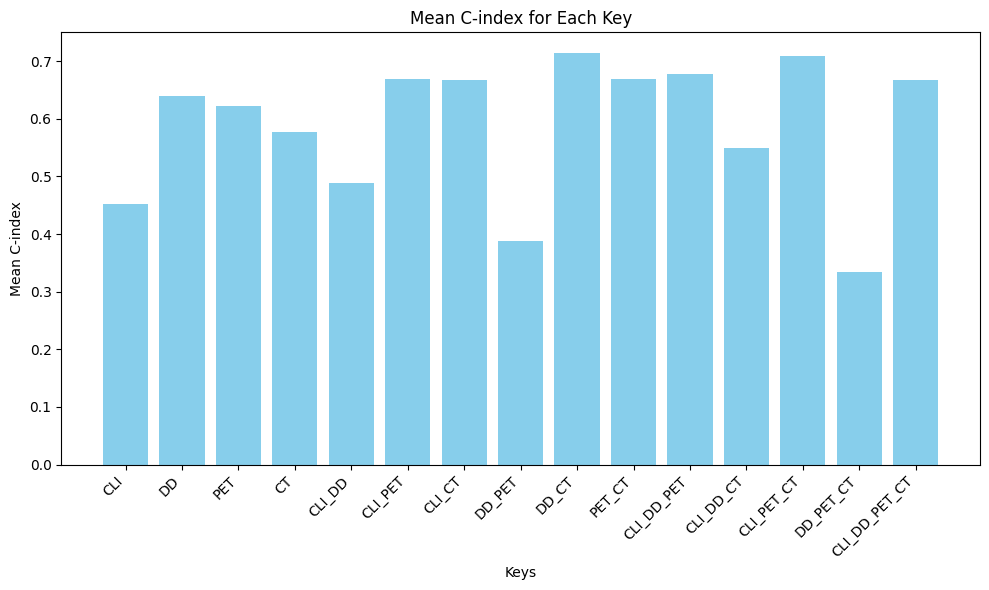

In [ ]:
c_indexes_cv = {key: result['CI'] for key, result in results_dict_lasso.items()}
# Call the function with the C-index values
plot_c_indexes(c_indexes_cv)

### **Principal Component Analysis (PCA) with Cox Proportional Hazards Model**

This section is dedicated to exploring how dimensionality reduction, specifically using PCA, affects the predictive power of the Cox Proportional Hazards model on various datasets. The goal is to determine the optimal number of principal components that yield the highest Concordance Index (CI) for each dataset.

Procedure:

Data Splitting: For each dataset, the data is segmented into training and testing subsets.
PCA & Model Evaluation: For a set of specified principal components ([5, 7, 10]), the data is subjected to PCA. A 5-fold cross-validation is then conducted, evaluating the CI for the Cox model on the transformed data.
Optimal Component Selection: For each dataset, the number of components yielding the highest average CI across the folds is considered optimal.
Results

In [ ]:
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

results_dict_pca = {}

for name, df in dataframes_allt.items():
    if name == "CLI":
      continue

    print(f"Processing {name}")

    # Splitting data for this specific dataframe
    common_idx = df.index.intersection(survival.index)
    X_train, X_test, y_train, y_test = train_test_split(df.loc[common_idx], survival.loc[common_idx], test_size=0.2, random_state=42)

    best_score = 0
    best_components = None
    for components in [5, 7, 10]:
        # Scale and apply PCA
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train_scaled)

        scores = []
        kfold = KFold(n_splits=5)
        for train_idx, val_idx in kfold.split(X_train_pca, y_train):
            X_train_fold = X_train_pca[train_idx]
            y_train_fold = y_train.iloc[train_idx]
            X_val_fold = X_train_pca[val_idx]
            y_val_fold = y_train.iloc[val_idx]

            # Combining features and target for lifelines input
            train_dataset = pd.concat([pd.DataFrame(X_train_fold), y_train_fold.reset_index(drop=True)], axis=1)
            val_dataset = pd.concat([pd.DataFrame(X_val_fold), y_val_fold.reset_index(drop=True)], axis=1)

            cph = CoxPHFitter()
            cph.fit(train_dataset, duration_col='Survival', event_col='Death')
            ci = cph.score(val_dataset, scoring_method="concordance_index")
            scores.append(ci)

        mean_score = sum(scores) / len(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_components = components

    results_dict_pca[name] = {"Best Components": best_components, "Best CI": best_score}

# Display the results
for name, result in results_dict_pca.items():
    print(f"{name}: Best Components = {result['Best Components']}, Best CI = {result['Best CI']}")

Processing DD
Processing PET
Processing CT
Processing CLI_DD
Processing CLI_PET
Processing CLI_CT
Processing DD_PET
Processing DD_CT
Processing PET_CT
Processing CLI_DD_PET
Processing CLI_DD_CT
Processing CLI_PET_CT
Processing DD_PET_CT
Processing CLI_DD_PET_CT
DD: Best Components = 5, Best CI = 0.69553514559447
PET: Best Components = 5, Best CI = 0.6697910146497631
CT: Best Components = 7, Best CI = 0.6574835481841754
CLI_DD: Best Components = 5, Best CI = 0.7274669010355046
CLI_PET: Best Components = 7, Best CI = 0.6950862716215674
CLI_CT: Best Components = 10, Best CI = 0.7269173216385383
DD_PET: Best Components = 10, Best CI = 0.6915186695148661
DD_CT: Best Components = 7, Best CI = 0.7084243356391211
PET_CT: Best Components = 5, Best CI = 0.6711389163338101
CLI_DD_PET: Best Components = 10, Best CI = 0.7239010757882418
CLI_DD_CT: Best Components = 7, Best CI = 0.7327451756178559
CLI_PET_CT: Best Components = 5, Best CI = 0.6655836750404953
DD_PET_CT: Best Components = 10, Best CI 

Next we ploit the Concordance Index (C-index) values for various omics and multi-omics datasets. This C-index is a measure of the model's predictive accuracy

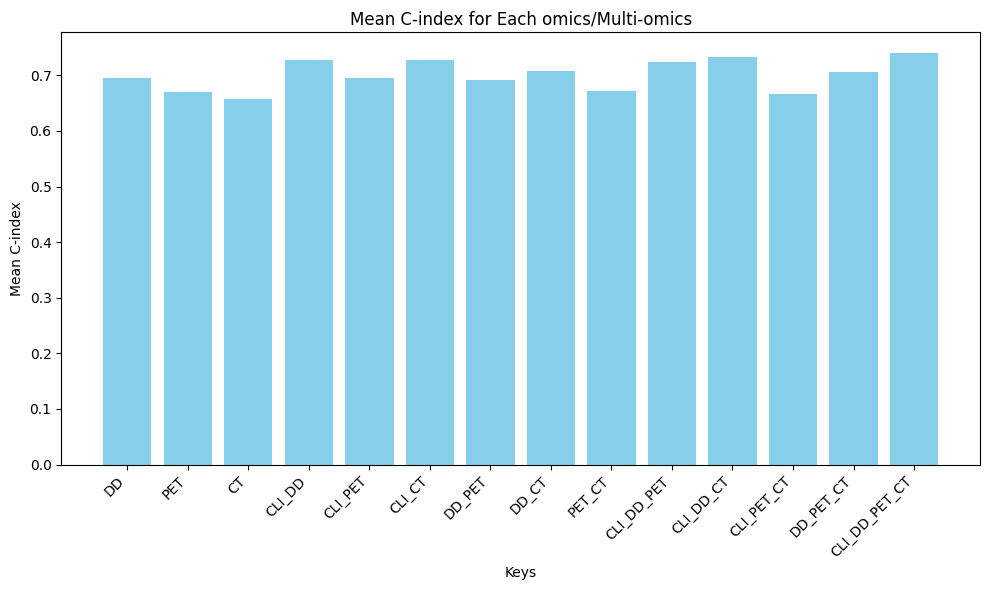

In [ ]:
c_indexes_cv = {key: result['Best CI'] for key, result in results_dict_pca.items()}
# Call the function with the C-index values
plot_c_indexes(c_indexes_cv)

**Question**: Based on the observed differences in results between PCA and LASSO, what insights can you derive? Additionally, what elements or methodologies could be introduced to stabilize and improve our model further?